<a href="https://colab.research.google.com/github/Willlee0225/nbviewer/blob/master/%E8%A8%88%E7%AE%97%E6%A9%9F%E7%A8%8B%E5%BC%8F_%E6%9C%9F%E6%9C%AB%E5%A0%B1%E5%91%8A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 計算機程式 - 期末報告
### 組員名單:
### 應數一 金函柔
### 應數一 王智萱
### 教育一 張鈞庭
### 金融四 李昱慶
### 專案分工
### 蒐集資料： 金函柔，王智萱，張鈞庭，李昱慶
### 模型建立： 李昱慶
### 模型回測： 金函柔，王智萱，張鈞庭
### 預測分析： 李昱慶，金函柔，王智萱，張鈞庭

## 專案動機
### 1.油價戰爭
### 2.武漢肺炎
### 3.影響美股
### 4.研究原油與美股的走勢
## 挫折與嘗試
### 1.利用原油預測，結果不符預期
### 2.影響股價的原因不只一種
### 3.放入道瓊成分股一起預測
### 4.五天預測五天範圍太大，改成五天預測一天


## 問題
### 利用道瓊指數成分股、石油價格和相關指數走勢來預測道瓊指數的漲跌
## 主題介紹
### 輸入：道瓊成分股（24支）、S&P500、NASDAQ、BP從1987/5/20至2020/5/13的每日歷史收盤價格
### 輸出：道瓊未來五天預測收盤價格模型：因處理與時間相關的資料，我們選擇使用RNN的LSTM模型


## 實作方法
### 我們這次是使用RNN裡面的LSTM，因為RNN可以解決時間序列的問題，一般的標準神經網路，在inpute資料通常是沒有時間性的資料。而RNN透過將Hidden layer的output存在Memory裡，當下次input資料進去時，會同時考慮上一次存在Memory的值進行計算。

## 先將所需的套件獨進來

In [0]:
#coding=utf-8
import pandas as pd
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.


In [0]:
%tensorflow_version 2.x

## 資料來源
### 我們都是從yahoo finance 上面抓資料下來，存成csv檔，再把他讀入colab

In [0]:
ur1 = 'https://raw.githubusercontent.com/108102018/AIwork/master/data.csv'
data = pd.read_csv(ur1)

## 由於各項Features 的差距其實蠻大的，為了不要失真，我們將所有資料進行標準化，讓所有資料都介於-1~1之間

In [0]:
def normalize(df):
    norm = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return norm

## 1. LSTM model 有許多種變化，One to One 、 One to many 、 Many to one 或者 Many to many，經過多次嘗試，我們決定使用Many to one，亦即利用前五天的資料來預測下一天的漲跌，因此Input就是前五天的股價，而輸出就是第六天的股價。將5天的資料視為一句話(一個序列的意思)
## 2. 用迴圈方式依序創建 X_train 跟 Y_train

In [0]:
def train_windows(df, ref_day=5, predict_day=1):
    X_train, Y_train = [], []
    for i in range(df.shape[0]-predict_day-ref_day):
        X_train.append(np.array(df.iloc[i:i+ref_day,:-1]))
        Y_train.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]["y"]))
    return np.array(X_train), np.array(Y_train)

### 將DOW 的每一個值都往前移一天

In [0]:
data['week_trend'] = np.where(data.DOW.shift(-5) > data.DOW, 1, 0)

### 進行標準化

In [0]:
data

,Date,MMM,KO,CVX,CAT,BA,AXP,AAPL,XOM,WMT,WBA,VZ,UNH,TRV,PG,NIKE,MSFT,MRK,JPM,JNJ,INTC,IBM,HD,DIS,MCD,SP,NASDAQ,DOW,BP,week_trend
0,1987/5/20,15.875000,2.437500,14.125000,6.375000,9.500000,8.239491,1.330357,10.921875,3.328125,2.171875,13.967607,0.183594,10.625000,5.515625,0.238281,0.380208,8.270833,13.208333,5.156250,0.869792,39.156250,0.663923,4.932500,6.270833,278.209991,406.600006,2215.870117,18.63,1
1,1987/5/21,15.781250,2.421875,14.156250,6.406250,9.500000,8.496975,1.330357,10.906250,3.453125,2.171875,13.827087,0.183594,10.687500,5.406250,0.242188,0.387153,8.375000,13.708333,5.164063,0.869792,39.312500,0.672154,5.014709,6.354167,280.170013,408.500000,2225.770020,18.45,1
2,1987/5/22,15.859375,2.492188,14.125000,6.437500,9.611111,8.529160,1.323661,10.843750,3.492188,2.171875,14.164333,0.183594,10.687500,5.500000,0.242188,0.375868,8.500000,13.916667,5.187500,0.830729,39.156250,0.674897,5.024984,6.552083,282.160004,407.399994,2243.199951,18.55,1
3,1987/5/26,16.156250,2.609375,14.312500,6.609375,9.694445,9.011943,1.392857,10.984375,3.562500,2.210938,14.445372,0.187500,11.000000,5.773438,0.242188,0.380208,8.479167,14.375000,5.289063,0.885417,40.156250,0.688615,5.220229,6.718750,289.109985,411.399994,2297.939941,18.63,0
4,1987/5/27,16.187500,2.578125,14.343750,6.734375,10.055555,8.915386,1.419643,10.937500,3.593750,2.226563,14.726410,0.183594,11.062500,5.710938,0.246094,0.380208,8.583333,14.000000,5.273438,0.885417,40.250000,0.732510,5.261333,6.708333,288.730011,412.600006,2295.810059,18.60,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,2011/2/28,92.230003,31.959999,103.750000,102.930000,72.010002,43.570000,50.458572,85.529999,51.980000,43.340000,36.919998,42.580002,59.930000,63.049999,22.257500,26.580000,32.570000,46.689999,61.439999,21.469999,161.880005,37.470001,43.740002,75.680000,1327.219971,2782.270020,12226.339840,116.14,0
5996,2011/3/1,90.459999,32.455002,102.900002,99.860001,70.120003,43.150002,49.901428,84.800003,52.070000,42.720001,36.020000,42.450001,59.220001,62.740002,21.924999,26.160000,32.459999,45.599998,60.700001,21.389999,159.970001,36.759998,42.990002,74.889999,1306.329956,2737.409912,12058.019530,118.43,0
5997,2011/3/2,91.320000,32.215000,103.470001,100.970001,69.570000,43.020000,50.302856,85.080002,51.970001,41.840000,36.340000,43.560001,58.810001,62.410000,22.082500,26.080000,32.580002,45.209999,60.810001,21.490000,160.160004,36.660000,43.290001,74.690002,1308.439941,2748.070068,12066.799810,119.95,0
5998,2011/3/3,92.809998,32.785000,104.190002,104.250000,71.709999,44.299999,51.365715,85.820000,52.009998,42.529999,36.360001,44.790001,59.049999,62.549999,22.459999,26.200001,33.099998,46.080002,61.049999,21.790001,163.479996,37.549999,44.070000,76.239998,1330.969971,2798.739990,12258.200200,118.71,0


### 整理資料

In [0]:
df1 = df1.dropna()

In [0]:
df1

,Date,MMM,KO,CVX,CAT,BA,AXP,AAPL,XOM,WMT,WBA,VZ,UNH,TRV,PG,NIKE,MSFT,MRK,JPM,JNJ,INTC,IBM,HD,DIS,MCD,SP,NASDAQ,DOW,BP,y
0,1987/5/20,-0.391240,-0.408381,-0.279582,-0.225023,-0.327997,-0.303430,-0.096468,-0.302566,-0.432710,-0.389112,-0.347755,-0.263915,-0.424680,-0.412268,-0.280273,-0.292198,-0.332677,-0.255000,-0.461732,-0.210806,-0.174009,-0.328166,-0.413328,-0.285216,-0.435624,-0.239917,-0.417921,-0.125371,-0.417194
1,1987/5/21,-0.392379,-0.408753,-0.279253,-0.224714,-0.327997,-0.299212,-0.096468,-0.302746,-0.430839,-0.389112,-0.350628,-0.263915,-0.423461,-0.413812,-0.280102,-0.292081,-0.331476,-0.246973,-0.461617,-0.210806,-0.173006,-0.328046,-0.411287,-0.284117,-0.434163,-0.239518,-0.417124,-0.126706,-0.415791
2,1987/5/22,-0.391430,-0.407081,-0.279582,-0.224405,-0.326882,-0.298685,-0.096598,-0.303468,-0.430254,-0.389112,-0.343732,-0.263915,-0.423461,-0.412489,-0.280102,-0.292271,-0.330036,-0.243629,-0.461273,-0.211331,-0.174009,-0.328006,-0.411032,-0.281505,-0.432679,-0.239749,-0.415721,-0.125964,-0.411386
3,1987/5/26,-0.387825,-0.404295,-0.277609,-0.222704,-0.326045,-0.290776,-0.095252,-0.301845,-0.429202,-0.388328,-0.337984,-0.263854,-0.417369,-0.408629,-0.280102,-0.292198,-0.330276,-0.236271,-0.459784,-0.210595,-0.167590,-0.327805,-0.406186,-0.279306,-0.427497,-0.238908,-0.411316,-0.125371,-0.411557
4,1987/5/27,-0.387445,-0.405038,-0.277281,-0.221467,-0.322419,-0.292358,-0.094731,-0.302386,-0.428734,-0.388015,-0.332237,-0.263915,-0.416151,-0.409511,-0.279931,-0.292198,-0.329076,-0.242291,-0.460013,-0.210595,-0.166988,-0.327163,-0.405166,-0.279444,-0.427780,-0.238656,-0.411488,-0.125593,-0.410360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5994,2011/2/25,0.511917,0.298127,0.645838,0.721314,0.302581,0.274685,0.845049,0.556022,0.292033,0.408916,0.102186,0.400664,0.530092,0.397009,0.672271,0.149189,-0.057084,0.282338,0.337282,0.071653,0.616259,0.204808,0.530306,0.614195,0.341029,0.259261,0.379982,0.592241,0.387630
5995,2011/2/28,0.535961,0.293491,0.663194,0.730517,0.299669,0.275341,0.859080,0.558214,0.295475,0.436387,0.121613,0.401606,0.536525,0.399973,0.683764,0.149695,-0.052705,0.282498,0.363679,0.066405,0.613692,0.210516,0.549915,0.630555,0.346501,0.259517,0.387699,0.597729,0.374084
5996,2011/3/1,0.514467,0.305259,0.654253,0.700136,0.280692,0.268460,0.848244,0.549792,0.296822,0.423955,0.103208,0.399565,0.522683,0.395597,0.669207,0.142611,-0.053973,0.265000,0.352827,0.065328,0.601433,0.200125,0.531299,0.620132,0.330926,0.250086,0.374153,0.614711,0.374790
5997,2011/3/2,0.524910,0.299553,0.660249,0.711121,0.275169,0.266331,0.856052,0.553022,0.295326,0.406309,0.109752,0.416990,0.514690,0.390938,0.676102,0.141262,-0.052590,0.258739,0.354440,0.066674,0.602652,0.198661,0.538745,0.617493,0.332499,0.252327,0.374860,0.625983,0.390194


## 將測試資料讀進來

In [0]:
ur2 = 'https://raw.githubusercontent.com/108102018/AIwork/master/test.csv'
df2 = pd.read_csv(ur2)

In [0]:
df2['y'] = df2['DOW'].shift(-1)

In [0]:
df2.iloc[:,[1,2,3,4,5,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]]=normalize(df2.iloc[:,[1,2,3,4,5,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]])

In [0]:
df2 = df2.dropna()

In [0]:
df1.drop(['Date'], axis=1, inplace=True)

In [0]:
df2.drop(['Date'], axis=1, inplace=True)

In [0]:
df2

,MMM,KO,CVX,CAT,BA,AXP,AAPL,XOM,WMT,WBA,VZ,UNH,TRV,PG,NIKE,MSFT,MRK,JPM,JNJ,INTC,IBM,HD,DIS,MCD,SP,NASDAQ,DOW,BP,y
0,-0.315591,-0.332992,-0.091327,-0.014504,-0.282607,-0.390056,-0.268788,0.023090,-0.326172,-0.303074,-0.437687,-0.363020,-0.404729,-0.320634,-0.344815,-0.234754,-0.391406,-0.243370,-0.461060,-0.280326,-0.033685,-0.388773,-0.375683,-0.337138,-0.347393,-0.327854,-0.354171,0.407402,-0.347743
1,-0.308398,-0.325832,-0.081901,0.003199,-0.279580,-0.373878,-0.268585,0.021444,-0.321167,-0.295097,-0.421452,-0.361995,-0.403803,-0.315680,-0.344028,-0.233602,-0.388995,-0.232635,-0.457891,-0.281949,-0.014269,-0.387995,-0.374216,-0.342200,-0.342282,-0.325162,-0.347590,0.356702,-0.347811
2,-0.311488,-0.326173,-0.102117,-0.012468,-0.279449,-0.375887,-0.270251,0.018427,-0.318426,-0.291847,-0.415580,-0.359490,-0.400656,-0.316409,-0.344728,-0.233724,-0.384014,-0.231215,-0.461060,-0.280529,0.015311,-0.385112,-0.374868,-0.340580,-0.343069,-0.327040,-0.347658,0.356880,-0.359903
3,-0.328324,-0.331799,-0.140068,-0.047607,-0.281537,-0.386778,-0.273187,-0.022708,-0.318664,-0.301449,-0.424216,-0.362147,-0.408802,-0.323840,-0.346973,-0.236633,-0.390281,-0.240354,-0.469133,-0.288849,-0.016417,-0.387858,-0.380168,-0.334505,-0.353961,-0.333817,-0.359750,0.348400,-0.356739
4,-0.319799,-0.339982,-0.129526,-0.033180,-0.280623,-0.384029,-0.270494,-0.012561,-0.319379,-0.301892,-0.443214,-0.362906,-0.405469,-0.323840,-0.349919,-0.234997,-0.393013,-0.238491,-0.468316,-0.287225,-0.013029,-0.387537,-0.376417,-0.334168,-0.349951,-0.331867,-0.356585,0.334743,-0.359450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2307,-0.028963,0.080919,-0.252061,0.034531,-0.149573,0.035978,0.616771,-0.535391,0.523209,-0.312677,0.240378,0.567710,-0.086947,0.428163,0.427606,0.715728,0.320309,0.156594,0.435006,0.490169,-0.337412,0.467252,0.096104,0.342398,0.325254,0.488677,0.258368,-0.456384,0.269395
2308,-0.031414,0.075804,-0.219939,0.031168,-0.131854,0.064845,0.627794,-0.531963,0.506407,-0.320654,0.238306,0.553400,-0.063712,0.414613,0.429006,0.722152,0.295883,0.164934,0.429998,0.489966,-0.353441,0.492560,0.134346,0.370408,0.339583,0.505422,0.269548,-0.452100,0.293496
2309,-0.016656,0.127287,-0.184841,0.073831,-0.119354,0.094136,0.650441,-0.505362,0.518919,-0.305733,0.287356,0.560992,-0.049457,0.469690,0.451172,0.728698,0.308739,0.178154,0.441342,0.500112,-0.338899,0.515350,0.163619,0.371151,0.360839,0.524357,0.293650,-0.452367,0.287711
2310,-0.031467,0.107853,-0.210885,0.042852,-0.131175,0.050041,0.667736,-0.511396,0.527618,-0.305142,0.266631,0.567406,-0.066397,0.460365,0.456655,0.741184,0.333004,0.153932,0.445532,0.509447,-0.342204,0.525098,0.152285,0.368789,0.361009,0.533850,0.287864,-0.457098,0.263515


### 建立LSTM模型，LSTM輸入必須是三維的，我們可以把一個二維序列映射成有5個樣本、時間步長為5、28個特徵的三維序列，主要使用兩層lstm以及兩層dense進行預測，activation function 選擇sigmoid，在利用TimeDistributed層來處理LSTM隱藏層的輸出，解決序列預測問題。

1. 輸入必須(至少)是三維的。這就意味著需要在TimeDistributed包裝密集層前配置最後一個LSTM層以便返回序列(例如將「return_sequences」參數設置為「True」)
2. 輸出將也是三維的。如果TimeDistributed包裝密集層是輸出層，並且是用於預測序列，那麼就得將y數組的大小調整成三維的向量。
3. 通過將「return_sequences」參數設置為「True」來定義LSTM隱藏層返回序列而不是單獨的一個值。
4. 之後在使用Flatten 壓縮回二維


### 定義一個每次有1個輸入的網絡模型，第一個隱藏層是有5個神經元的LSTMs，輸出層是只有一個輸出的全連接層，模型採用有效的ADAM優化算法，均方差誤差作為損失函數。

In [0]:
def lstm_stock_model(shape):
    model = Sequential()
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5,activation='tanh'))
    model.add(Dense(1,activation='tanh'))
    model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
    model.summary()
    return model


In [0]:
X_train, Y_train = train_windows(df1, 5, 1)
X_test, Y_test = train_windows(df2, 5, 1)

In [0]:
model = lstm_stock_model(X_train.shape)
callback = EarlyStopping(monitor="mean_absolute_error", patience=10, verbose=5, mode="auto")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 256)            291840    
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 1)              257       
_________________________________________________________________
flatten_1 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 817,445
Trainable params: 817,445
Non-trainable params: 0
________________________________________________

### 訓練資料

In [0]:
history = model.fit(X_train, Y_train, epochs=50, batch_size=1, validation_split=0.1, callbacks=[callback],shuffle=True)

Train on 5393 samples, validate on 600 samples
Epoch 1/50
5393/5393 [==============================] - 122s 23ms/step - loss: 0.0129 - mean_absolute_error: 0.0129 - val_loss: 0.0671 - val_mean_absolute_error: 0.0671
Epoch 2/50
5393/5393 [==============================] - 122s 23ms/step - loss: 0.0123 - mean_absolute_error: 0.0123 - val_loss: 0.0729 - val_mean_absolute_error: 0.0729
Epoch 3/50
5393/5393 [==============================] - 123s 23ms/step - loss: 0.0123 - mean_absolute_error: 0.0123 - val_loss: 0.0662 - val_mean_absolute_error: 0.0662
Epoch 4/50
5393/5393 [==============================] - 121s 22ms/step - loss: 0.0118 - mean_absolute_error: 0.0118 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376
Epoch 5/50
5393/5393 [==============================] - 121s 23ms/step - loss: 0.0119 - mean_absolute_error: 0.0119 - val_loss: 0.0673 - val_mean_absolute_error: 0.0673
Epoch 6/50
5393/5393 [==============================] - 123s 23ms/step - loss: 0.0115 - mean_absolute_error:

### 將損失函數讀出來

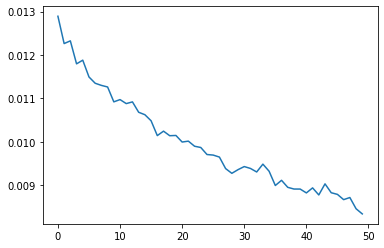

In [0]:
plt.plot(history.history['loss'])

## 劃出預測結果

In [0]:
real_stock_price = Y_test

In [0]:
real_stock_price

array([[-0.36673968],
       [-0.3795529 ],
       [-0.37101728],
       ...,
       [ 0.29349641],
       [ 0.28771056],
       [ 0.26351454]])

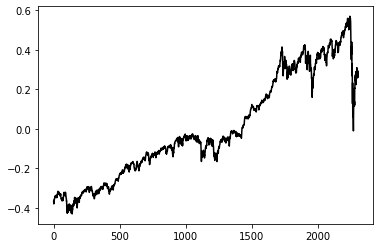

In [0]:
plt.plot(real_stock_price, color = 'black', label = 'DOW Stock Price')

In [0]:
predicted_stock_price = model.predict(X_test)

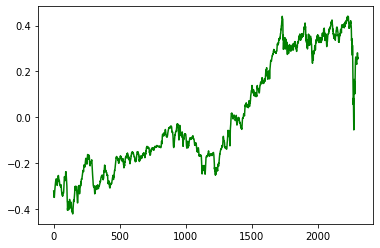

In [0]:
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted DOW Stock Price')

## 可以發現預測結果跟實際的Dow 指數漲跌大多數的時候其實是同步的，代表我們用前五天訓練的結果來預測第六天漲跌效果還不錯。
## 從上圖仔細看的，可看出上下偏移有時候問題其實蠻嚴重的，從視覺化來看還好，但是如果在想完全照這個方式去做股票買賣一定會造成很大問題，所以目前只建了漲跌預測比對。

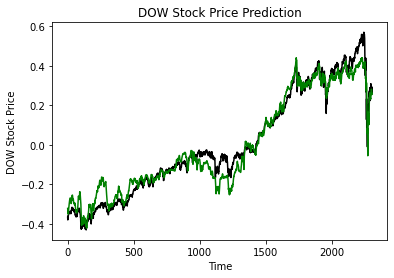

In [0]:
plt.plot(real_stock_price, color = 'black', label = 'DOW Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted DOW Stock Price')
plt.title('DOW Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('DOW Stock Price')
plt.show()

### 將漲跌預測做成互動，可以觀察測試資料的準確度
### 因為使用colab，所以會在報告中展現。

In [0]:
def RNNmodel_predict(n):
    print("實際的道瓊指數是：", real_stock_price[n:n+10])
    print("神經網路RNN的預測是：", predicted_stock_price[n:n+10])

In [0]:
from ipywidgets import interact_manual
interact_manual(RNNmodel_predict, n=(0, 2216))

interactive(children=(IntSlider(value=1108, description='n', max=2216), Button(description='Run Interact', sty…

<function __main__.RNNmodel_predict>